In [1]:
from graphdatascience import GraphDataScience

host = "bolt://localhost:7687"
user = "neo4j"
password= "letmein"

gds = GraphDataScience(host, auth=(user, password))

print(gds.version())

2.0.3


In [2]:
gds.run_cypher("""
CALL apoc.meta.stats()
""")

,labelCount,relTypeCount,propertyKeyCount,nodeCount,relCount,labels,relTypes,relTypesCount,stats
0,4,5,16,789856,1776743,"{'User': 33732, 'Device': 51451, 'IP': 585855,...","{'()-[:HAS_CC]->()': 128066, '()-[:HAS_CC]->(:...","{'HAS_IP': 1488949, 'REFERRED': 1870, 'USED': ...","{'relTypeCount': 5, 'propertyKeyCount': 16, 'l..."


In [3]:
df = gds.run_cypher("""
MATCH (u:User)
RETURN u.guid AS user_id,
       u.fraudRisk AS fraudRisk,
       u.moneyTransferErrorCancelAmount AS moneyTransferErrorCancelAmount,
       size((u)-[:USED]->()) AS numberOfDevices,
       size((u)-[:HAS_CC]->()) AS numberOfCCs,
       size((u)-[:HAS_IP]->()) AS numberOfIps,
       coalesce(apoc.coll.sum([(u)-[out:P2P]->() | out.totalAmount]), 0) AS totalOutgoingAmount,
       coalesce(apoc.coll.avg([(u)-[out:P2P]->() | out.totalAmount]), 0) AS avgOutgoingAmount,
       coalesce(apoc.coll.max([(u)-[out:P2P]->() | out.totalAmount]), 0) AS maxOutgoingAmount,
       coalesce(apoc.coll.sum([(u)<-[in:P2P]-() | in.totalAmount]), 0) AS totalIncomingAmount,
       coalesce(apoc.coll.avg([(u)<-[in:P2P]-() | in.totalAmount]), 0) AS avgIncomingAmount,
       coalesce(apoc.coll.max([(u)<-[in:P2P]-() | in.totalAmount]), 0) AS maxIncomingAmount,
       size((u)-[:P2P]->()) AS outgoingTransactions,
       size((u)<-[:P2P]-()) AS incomingTransactions
""")

In [4]:
df.head()

,user_id,fraudRisk,moneyTransferErrorCancelAmount,numberOfDevices,numberOfCCs,numberOfIps,totalOutgoingAmount,avgOutgoingAmount,maxOutgoingAmount,totalIncomingAmount,avgIncomingAmount,maxIncomingAmount,outgoingTransactions,incomingTransactions
0,6f5ff01e3c3d9213b330c1a36e4e0d56,0,16752.39,1,5,73,2272.0,98.782609,300.0,1000.00,83.333333,170.00,23,12
1,42489b0de3619b7558c170791fda29c3,0,14940.54,1,8,88,100.0,100.000000,100.0,100.00,100.000000,100.00,1,1
2,227146a1ca295356b58e812e00490df5,0,52773.22,1,13,171,206.0,206.000000,206.0,206.00,206.000000,206.00,1,1
3,665c3c081e8993803548d971b4e1814b,0,233.00,1,2,6,122.0,122.000000,122.0,167.22,83.610000,117.22,1,2
4,fda32eea75f7aab6b81f0654dd2120d0,0,734.29,1,7,39,0.0,0.000000,0.0,210.00,105.000000,200.00,0,2


In [5]:
df.groupby('fraudRisk').size().reset_index()

,fraudRisk,0
0,0,33521
1,1,211


<AxesSubplot:>

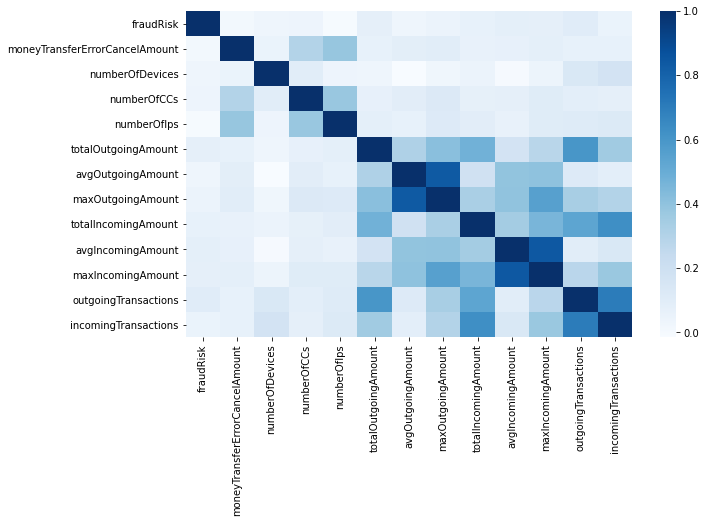

In [6]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 6]
import seaborn as sns
corr = df.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            cmap="Blues")

In [7]:
import pandas as pd

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelBinarizer, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, plot_roc_curve
from sklearn.metrics import ConfusionMatrixDisplay


from sklearn.ensemble import RandomForestClassifier

In [8]:
def feature_importance(columns, classifier):        
    features = list(zip(columns, classifier.feature_importances_))
    sorted_features = sorted(features, key = lambda x: x[1]*-1)
    
    keys = [value[0] for value in sorted_features]
    values = [value[1] for value in sorted_features]
    return pd.DataFrame(data={'feature': keys, 'value': values})

def get_roc_curve(df):
    df_X = df.drop('fraudRisk', axis=1)
    df_y = df[['fraudRisk']]

    X = df_X.values
    y = df_y.values

    y = LabelBinarizer().fit_transform(y)
    
    # Test/train data split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42, stratify=y)
    
    # Oversample only the training data
    oversample = SMOTE(random_state=42)
    X_train, y_train = oversample.fit_resample(X_train, y_train)

    # Random forrest classification
    model = RandomForestClassifier(n_estimators=500, random_state=42, max_depth=5, bootstrap=True, class_weight='balanced')
    model = model.fit(X_train, y_train)
    
    y_pred_test = model.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred_test, labels=model.classes_, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)
    disp.plot()
    
    plot_roc_curve(model, X_test, y_test)
    print(classification_report(y_test, y_pred_test))
    
    return feature_importance(df_X.columns.to_list(), model)

In [9]:
final_df = df[['fraudRisk', 'moneyTransferErrorCancelAmount', 'numberOfDevices', 'numberOfCCs', 'numberOfIps', 
               'totalOutgoingAmount','maxOutgoingAmount', 'avgOutgoingAmount',
               'totalIncomingAmount', 'maxIncomingAmount', 'avgIncomingAmount',
               'outgoingTransactions','incomingTransactions']]

              precision    recall  f1-score   support

           0       1.00      0.86      0.92      6705
           1       0.02      0.48      0.04        42

    accuracy                           0.86      6747
   macro avg       0.51      0.67      0.48      6747
weighted avg       0.99      0.86      0.92      6747



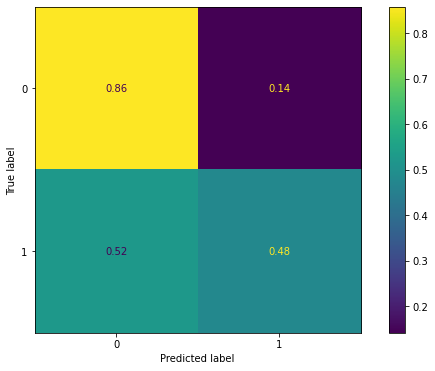

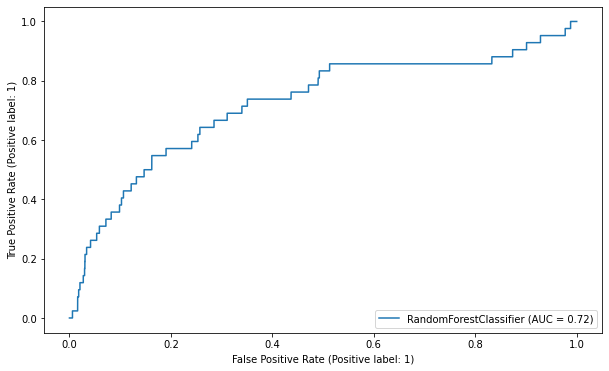

In [10]:
importance = get_roc_curve(final_df)


In [11]:
importance

,feature,value
0,numberOfDevices,0.321081
1,incomingTransactions,0.171387
2,maxIncomingAmount,0.118501
3,avgIncomingAmount,0.089415
4,totalIncomingAmount,0.085903
5,numberOfCCs,0.056310
6,maxOutgoingAmount,0.031297
7,totalOutgoingAmount,0.031240
8,avgOutgoingAmount,0.026115
9,outgoingTransactions,0.024785


In [12]:
# Enter graph

In [13]:
G, res = gds.graph.project('fraud', ['User', 'Card'], 
    {'HAS_CC':{
       'type':'HAS_CC'
    },
    'P2P':{
       'type':'P2P',
       'properties':{
          'totalAmount':{
             'aggregation':'SUM'
          }
       }
    }})

In [14]:
# User - Card WCC
graph_features = gds.wcc.stream(G, nodeLabels=['User', 'Card'], relationshipTypes=['HAS_CC'])
graph_features['node_object'] = gds.util.asNodes(graph_features['nodeId'].to_list())
# Filter only user nodes
graph_features = graph_features[[list(x.labels)[0] == 'User' for x in graph_features['node_object']]]
# Get component sizes
graph_features = graph_features.merge(graph_features.groupby('componentId').size().to_frame('componentSize').reset_index(), on="componentId")
graph_features['part_of_community'] = graph_features['componentSize'] > 1
graph_features['part_of_community'] = graph_features['part_of_community'].astype(int)

# Get user ids
graph_features['user_id'] = [el.get('guid') for el in graph_features['node_object']]

In [15]:
# pagerank
pr = gds.pageRank.stream(G, nodeLabels=['User'], relationshipTypes=['P2P'], relationshipWeightProperty='totalAmount')
pr['pagerank'] = pr['score']
graph_features = graph_features.merge(pr[['nodeId', 'pagerank']], on='nodeId')
# Closeness centrality
bc = gds.beta.closeness.stream(G, nodeLabels=['User'], relationshipTypes=['P2P'])
bc['closeness'] = bc['score']
graph_features = graph_features.merge(bc[['nodeId', 'closeness']], on='nodeId')
# Merge to original df
df = df.merge(graph_features[['user_id', 'componentSize', 'part_of_community', 'pagerank', 'closeness']], on='user_id')

In [16]:
# Drop the projected graph
G.drop()

In [17]:
final_df = df[['fraudRisk', 'moneyTransferErrorCancelAmount', 'numberOfDevices', 'numberOfCCs', 'numberOfIps', 
               'totalOutgoingAmount','maxOutgoingAmount', 'avgOutgoingAmount',
               'totalIncomingAmount', 'maxIncomingAmount', 'avgIncomingAmount',
               'outgoingTransactions','incomingTransactions', 'componentSize', 'part_of_community', 'pagerank', 'closeness']]

              precision    recall  f1-score   support

           0       1.00      0.90      0.95      6705
           1       0.05      0.76      0.09        42

    accuracy                           0.90      6747
   macro avg       0.52      0.83      0.52      6747
weighted avg       0.99      0.90      0.94      6747



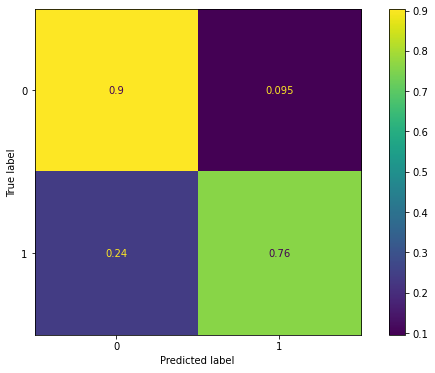

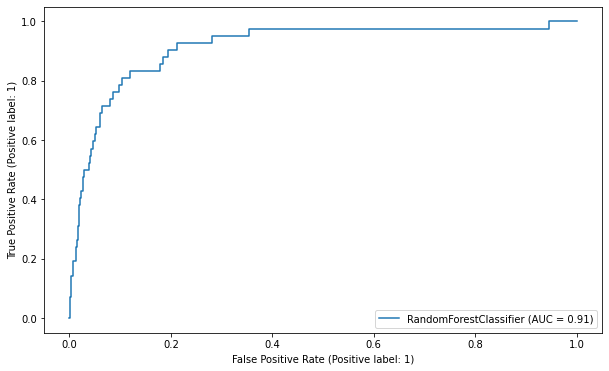

In [18]:
importance = get_roc_curve(final_df)

In [19]:
importance

,feature,value
0,componentSize,0.404256
1,part_of_community,0.288862
2,numberOfDevices,0.088540
3,incomingTransactions,0.044568
4,maxIncomingAmount,0.036755
5,closeness,0.028991
6,avgIncomingAmount,0.028216
7,totalIncomingAmount,0.019441
8,numberOfIps,0.012721
9,numberOfCCs,0.010989
